# Fake News dataset exploration & preprocessing
by Marcin Rybok

In [1]:
import pandas as pd
import seaborn as sns

from collections import Counter

In [2]:
bodies  = pd.read_csv('data/fake_news/bodies.csv')
stances = pd.read_csv('data/fake_news/stances.csv')
test_bodies = pd.read_csv('data/fake_news/competition_test_bodies.csv')
bodies = pd.concat((bodies, test_bodies))

In [3]:
# Check for null values
bodies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2587 entries, 0 to 903
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      2587 non-null   int64 
 1   articleBody  2587 non-null   object
dtypes: int64(1), object(1)
memory usage: 60.6+ KB


In [4]:
stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [5]:
# Check for duplicates
unique_count = bodies.groupby('articleBody').agg(['unique', 'nunique'])
duplicates   = unique_count[unique_count['Body ID']['nunique'] > 1]['Body ID']['unique'].tolist()

print(f'Number of body duplicates: {len(duplicates)}')

Number of body duplicates: 28


In [6]:
# Map second duplicate in a pair to ID of the first body
duplicates = {non_first_duplicate: ids[0] for ids in duplicates for non_first_duplicate in ids[1:]}

# Remove duplicates
bodies = bodies.drop_duplicates(subset='articleBody', keep='first')

print(f'Number of bodies after duplicate removal: {len(bodies)}')

Number of bodies after duplicate removal: 2559


In [7]:
# Fix the Body IDs of removed duplicate bodies in the Stances table
stances['Body ID'] = stances['Body ID'].apply(lambda body_id: duplicates[body_id] if body_id in duplicates else body_id)

# Remove duplicated Headline - Body pairs
stances = stances.drop_duplicates(subset=['Headline', 'Body ID'], keep='first')

print(f'Number of headline-body pairs after duplicate removal: {len(stances)}')

Number of headline-body pairs after duplicate removal: 49538


In [8]:
unique_heads = set(stances["Headline"])

print(f'Number of unique headlines: {len(unique_heads)}')

Number of unique headlines: 1648


In [9]:
# Replace headline by ID in Stances table
# Useful later for faster tokenizing (1,500 instead of 50,000 headlines)
max_body_id = max(stances['Body ID']) + 1
head_to_id  = {headline: idx + max_body_id for idx, headline in enumerate(unique_heads)}

stances['Headline'] = stances['Headline'].apply(lambda headline: head_to_id[headline])

In [10]:
# Check for data points with conflicting labels
num_conflicts = (stances.groupby(['Headline', 'Body ID']).agg('nunique') > 1)['Stance'].sum()

print(f'Num conflicting data points: {num_conflicts}')

Num conflicting data points: 0


In [11]:
# Check class distribution
dist = sorted(Counter(stances['Stance']).items(), key=lambda x: x[1])

print(f'Dataset size: {len(stances)}\n')
print('Class distribution:')

for label, count in dist:
    print(f'    {label:<9s}: {count * 100 / len(stances):>5.2f}%, ({count:>5d})')

Dataset size: 49538

Class distribution:
    disagree :  1.67%, (  829)
    agree    :  7.35%, ( 3643)
    discuss  : 17.77%, ( 8804)
    unrelated: 73.20%, (36262)


## Dataset partitioning problem

For ML we need to split the dataset into train / validation / test sets.
The project GitHub repository offers a ready test set, so I am going to use it.
I need to split the available dataset to train and validation only.

Splitting aims:
- Maintain original class distribution in train & valid set
- The splits are mutually exclusive

**Problem**:
The mapping between headlines and bodies is many-to-many.
We cannot have a headline that occurs both in train set and validation set pair.
Otherwise, we have data leakage from train to the validation set.
Validation set will produce over-optimistic estimates in hyperparameter tunning.

We need to assign each headline and body either to train or validation dataset.
Then remove the Stance pairings in which headline and body are not in the same set.
*(The removal is temporary for hyperparameter tunning only. After finding good hyperparameters we retrain on the entire dataset.)*
There are $2^{N}$ possible splits to consider ($N$ being number of bodies and headlines).
Combinatorial problem - too costly to consider all splits.
The problem is a graph coloring one so use breadth-first search (BFS) to find a suboptimal split.

New splitting aims:
- Maintain original class distribution in train & valid set
- The pairing splits are mutually exclusive
- Each Headline and Body is assigned to train or valid set only.
- Minimize the number of inter-split Body-Headline connections, to maximize the number of training examples.

The implementation is in `util.split_data` function.

In [12]:
from util import split_data

In [13]:
new_stances = split_data(stances, valid_size=0.05, seed=6)

  0%|          | 0/2476 [00:00<?, ?it/s]

In [14]:
# Test set preprocessing
test_stances = pd.read_csv('data/fake_news/competition_test_stances.csv')

test_stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25413 entries, 0 to 25412
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  25413 non-null  object
 1   Body ID   25413 non-null  int64 
 2   Stance    25413 non-null  object
dtypes: int64(1), object(2)
memory usage: 595.7+ KB


In [15]:
print(f'Original test set size: {len(test_stances)}')

# Fix the Body IDs of removed duplicate bodies in the test stances table
test_stances['Body ID'] = test_stances['Body ID'].apply(lambda body_id: duplicates[body_id] if body_id in duplicates else body_id)

# Remove duplicated Headline - Body pairs
stances = stances.drop_duplicates(subset=['Headline', 'Body ID'], keep='first')

# Remove any test set example, of which body or headline occurs in train or validation
old_bodies = set(pd.read_csv('data/fake_news/bodies.csv')['Body ID'])
logical_idx = test_stances.apply(lambda row: row['Headline'] not in head_to_id and row['Body ID'] not in old_bodies, axis=1)
test_stances = test_stances[logical_idx]

test_stances['split'] = ['test'] * len(test_stances)
max_head_id = max(head_to_id.values()) + 1

for idx, head in enumerate(set(test_stances['Headline'])):
    head_to_id[head] = idx + max_head_id

test_stances['Headline'] = test_stances['Headline'].apply(lambda head: head_to_id[head])

print(f'Preprocessed test set size: {len(test_stances)}')

new_stances = pd.concat((new_stances, test_stances))

Original test set size: 25413
Preprocessed test set size: 25043


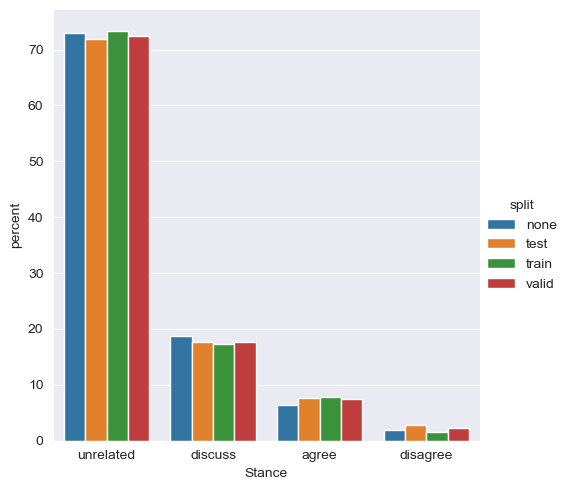

In [16]:
split_display = new_stances.groupby('split')['Stance'].value_counts(normalize=True).mul(100).rename('percent')

split_display.reset_index().pipe((sns.catplot, 'data'), x='Stance', y='percent', hue='split', kind='bar');

In [17]:
labels = {'unrelated': 0, 'agree': 1, 'disagree': 2, 'discuss': 3}

print(f'{" ":<5s} | total | data % | unrelated | {"agree":>8s} | disagree | {"discuss":>8s}')
print("-------------------------------------------------------------------")

for split in ['train', 'valid', 'none']:
    filtered = new_stances[new_stances['split'] == split]
    n = len(filtered)
    total = sum(new_stances['split'] != 'test')

    aux = lambda label: f'{((filtered["Stance"] == label).sum() * 100 / n):>8.2f}%'
    str_rep = " |".join([aux(label) for label in labels])
    print(f'{split:<5s} | {n:5d} | {(n * 100 / total):>5.2f}% |', str_rep)

      | total | data % | unrelated |    agree | disagree |  discuss
-------------------------------------------------------------------
train | 31161 | 62.90% |    73.40% |    7.80% |    1.52% |   17.27%
valid |  2501 |  5.05% |    72.49% |    7.52% |    2.36% |   17.63%
none  | 15876 | 32.05% |    72.92% |    6.45% |    1.86% |   18.77%


The algorithm I have used for data splitting produces well-balanced splits in terms of classes.
Drawback: many examples must be rejected.
I have tried different expansion method, that selected the least connected nodes for expansion in BFS.
The previous method rejected significantly less inter-split connections, but split class distributions varied significantly.
*(3 times lower proportion of "agree" examples in a train set compared to validation)*
There are no free-lunches :(

**Finally, I use 5% of Headline-Body pairings as the validation set. 63% pairs are left for training. The remaining 32% of data must be left out from the hyper-parameter tunning process, to prevent same examples in training and validation sets.**
*(percentages do not consider the test set examples)*
*(I use 5% of data in validation set because when I have tried 10% the train set had only 40% of examples)*

### Digression
Creating more *"unrelated"* pairings by randomly assigning more headlines to bodies is a good data augmentation method.
Its unlikely that such random assignment would produce a *"related"* pair.
However, most of the pairings are already *"unrelated"*.
Headlines are paired with multiple bodies.
The method was probably already used in the dataset creation.

### Task & solution
The task is to determine whether Headline matches the article Body.
It is very similar to sentence entailment.
BERT is pre-trained to predict whether one sentence supersedes another, so it is naturally suited for the task.
I am going to represent each Headline-Body pair as:
\<CLS\> Headline \<SEP\> Body \<SEP\>
So I will tokenize each Headline and Body.
Then I will feed the above representation to BERT.
From BERT's output, I will extract the last hidden state representation for the \<CLS\> token only.
Then I will feed the BERT-produced contextualized embeddings to a simple classifier head.
I will train the classifier head only, as I have no time to fine-tune BERT.
Hence, the BERT embedding for each Headline-Body pair will be produced once and stored.

### Caveats
The task is different from entailment in that the article Bodies are quite long.
Bodies often have lengths in thousands of tokens.
BERT accepts a sequence of length max 512.
Hence, I am going to always use the full tokenized Headline, but I will truncate the Body, so that together the:
\<CLS\> Headline \<SEP\> truncated-Body \<SEP\>
representation matches the maximum 512 tokens.
I will use only the initial Body tokens.
This will downgrade the performance.

### Alternatives:
- Instead of using the initial part of the Body, try using middle or random part. Might have a higher chance of containing key info for classification.
- Use multiple Body parts *(for example, start, middle and end)*: encode each as before, feed each representation separately into BERT. From each BERT output extract \<CLS\> token embedding, concatenate such embeddings together and feed them into classifier. Covers more article body text, but it is more computationally expensive. I have tried using end part also, but it took too long for my Nvidia RTX 2060 to compute the embeddings.
- Produce representations in Information Retrieval (IR) fashion. Case fold, tokenize, remove stop words, stem the Headlines & Bodies. Then represent each document sparsely based on the dictionary of left words in the dataset and try to build a classifier on top of this. Might be suitable due to lengthy Bodies - IR deals better with lengthy documents & semantics only.
- Task is also similar to text summarization, where we try to highlight important sentences in a document. Typically, one sentence in body will inform us whether the Headline matches it, so the task might be reduced to finding such most significant sentence. If I had more time, I would also look for solutions in this field.

## Prepare input for model

In [18]:
import torch
import pickle
import transformers

from tqdm.notebook      import tqdm
from transformers       import BertTokenizer
from torch.utils.data   import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

transformers.logging.set_verbosity_error()

In [19]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize every Headline and Body
id_to_head = {head_id: (head, tokenizer.encode(head, add_special_tokens=False)) for head, head_id in head_to_id.items()}
id_to_body = {body_id: (body, tokenizer.encode(body, add_special_tokens=False)) for body_id, body in bodies.itertuples(index=False)}

In [20]:
cls = tokenizer.cls_token_id
sep = tokenizer.sep_token_id
splits = ['train', 'valid', 'none', 'test']

dataset = {split: {'input_ids': [], 'segments': [], 'masks': [], 'y': []} for split in splits}

for row in tqdm(list(new_stances.itertuples(index=False))):
    head, body, stance, split = row

    head_ids = id_to_head[head][1]
    body_ids = id_to_body[body][1]

    body_len = min(len(body_ids), 512 - len(head_ids) - 3)

    body_ids = body_ids[:body_len]

    input_ids = [cls, *head_ids, sep, *body_ids, sep]
    segments  = [0] * (len(head_ids) + 2) + [1] * (body_len + 1)
    mask      = [1] * (body_len + len(head_ids) + 3)

    input_ids = torch.tensor(input_ids)
    segments  = torch.tensor(segments)
    mask      = torch.tensor(mask)

    dataset[split]['input_ids'] += [input_ids     ]
    dataset[split]['segments' ] += [segments      ]
    dataset[split]['masks'    ] += [mask          ]
    dataset[split]['y'        ] += [labels[stance]]

for split in dataset:
    for key in ['input_ids', 'segments', 'masks']:
        dataset[split][key] = pad_sequence(dataset[split][key], batch_first=True)

    dataset[split]['y'] = torch.tensor(dataset[split]['y'])

    loader = DataLoader(TensorDataset(*dataset[split].values()), batch_size=10, shuffle=False)

    with open(f'preprocessed/fake_news/bert_loaders/{split}.pkl', 'wb') as file:
        pickle.dump(loader, file)

del dataset

  0%|          | 0/74581 [00:00<?, ?it/s]

Now to generate BERT embeddings

`python embeddings.py`